# Import packages

In [1]:
## Generic packages that are on your operating system
import glob
import os
import time

## Additional required packages
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

## Important scikit-learn packages for fitting logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import SplineTransformer, PolynomialFeatures
from sklearn.calibration import calibration_curve
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


## Required definitions and constants

In [1104]:
files = glob.glob('datasets/IMERG*_Nairobi.zarr')
ds_IMERG = xr.open_mfdataset(files,engine="zarr")

latitude_IMERG = ds_IMERG.latitude.values
longitude_IMERG = ds_IMERG.longitude.values

box_left = longitude_IMERG-0.05
box_right = longitude_IMERG+0.05
box_down = latitude_IMERG-0.05
box_up = latitude_IMERG+0.05


def bounding_box(region,points,min_x=box_left,max_x=box_right,min_y=box_down,max_y=box_up):

    """
    points: latitude, longitude
    x: longitude
    y: latitude
    """

    section_x = []
    section_y = []
    
    for y_min, y_max in zip(box_down,box_up):
        section_y.append(np.logical_and(points[0]<=y_max,points[0]>=y_min))
            
    for x_min, x_max in zip(box_left,box_right):
        if region == 'J.K.I.A.':
            section_x.append(np.logical_and(points[1]<=x_max+0.01,points[1]>=x_min-0.01))
        else:
            section_x.append(np.logical_and(points[1]<=x_max,points[1]>=x_min))

    idx = np.squeeze(np.argwhere(np.logical_and(np.array(section_x),np.array(section_y))))

    return idx

# Load in data

In [1105]:
files = glob.glob('datasets/cGAN_50*_Nairobi.zarr')
ds_cGAN_50 = []
for file in files:
    ds_temp = xr.open_dataset(file,engine="zarr")
    if type(ds_temp['time'].values[0]) == np.float32:
        ds_temp['time'] = (ds_temp['time'].astype('datetime64[ns]')+np.timedelta64(1,'h')).astype('datetime64[D]').astype('datetime64[ns]')
    ds_cGAN_50.append(ds_temp) 
ds_cGAN_50 = xr.concat(ds_cGAN_50, 'time').sortby('time')

files = glob.glob('datasets/cGAN_2*_Nairobi.zarr')
ds_cGAN = []
for file in files:
    ds_temp = xr.open_dataset(file,engine="zarr")
    if type(ds_temp['time'].values[0]) == np.float32:
        ds_temp['time'] = (ds_temp['time'].astype('datetime64[ns]')+np.timedelta64(1,'h')).astype('datetime64[D]').astype('datetime64[ns]')
    ds_cGAN.append(ds_temp) 
ds_cGAN = xr.concat(ds_cGAN, 'time').sortby('time')

files = glob.glob('datasets/IFS*_Nairobi.zarr')
ds_IFS = []
for file in files:
    ds_IFS.append(xr.open_zarr(file).drop_duplicates('time',keep='last'))

ds_IFS = xr.concat(ds_IFS,'time')

#meta = pd.read_excel('SEWAA-data.xlsx',sheet_name='Gridded',index_col=0,nrows=2)
#data = pd.read_excel('SEWAA-data.xlsx',sheet_name='Gridded',index_col=0,skiprows=[1,2])

#ds = data.to_xarray().rename({'ID':'time'})

# Not sure if this is the best way but it works
#ds['time'] = np.array([t[:4]+'-'+t[4:6]+'-'+t[-2:] for t in ds['time'].values.astype(str)],dtype='datetime64[ns]')


/var/folders/z9/7vk0kbx55g91_3mr8vw6gt_80000gp/T/ipykernel_25448/4276229271.py:6: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds_temp['time'] = (ds_temp['time'].astype('datetime64[ns]')+np.timedelta64(1,'h')).astype('datetime64[D]').astype('datetime64[ns]')
/var/folders/z9/7vk0kbx55g91_3mr8vw6gt_80000gp/T/ipykernel_25448/4276229271.py:15: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This w

## Load observational point data

In [1106]:
def parser(vals):
    vals_temp = np.zeros_like(vals.flatten())
    for i, val in enumerate(vals.flatten()):
        if type(val) is str:
            try:
                vals_temp[i] = val.replace('..','.').replace(" ","").astype(np.float64)
            except:
                vals_temp[i] = 0
            
        else:
            vals_temp[i] = val
    
    return vals_temp.astype(np.float64)
    
file_path='SEWAA-data.xlsx'
sheets = pd.ExcelFile(file_path).sheet_names

meta = []
ds = []
for sheet in sheets[1:-1]:

    df_meta = pd.read_excel('SEWAA-data.xlsx',sheet_name=sheet)
    columns = df_meta.columns
    region = np.unique(df_meta['Station_Name'])
    region = [region[0].split(" ")[0]]
    try:
        lat = np.unique(df_meta['lat'])
        lon = np.unique(df_meta['lon'])
    except:
        lat = np.unique(df_meta['Lat'])
        lon = np.unique(df_meta['Lon'])
    meta.append(xr.DataArray(data=np.hstack((lon,lat))[None,:],
                            dims = ['region','ID'],
                            coords = {'region':region,
                                     'ID':['lon','lat']}))
    year_idx = np.squeeze(np.argwhere(columns=='Year'))
    use_cols = np.arange(33)+year_idx
    df = pd.read_excel('SEWAA-data.xlsx',sheet_name=sheet,
                       index_col=[0,1],usecols=use_cols)
    data = []
    times = []
    for year,month in df.index.values:
        if month!=12:
            times.append(np.arange(f'{year}-{month:02}-01',f'{year}-{month+1:02}-01',
                                   np.timedelta64(1,'D'),dtype='datetime64[ns]'))
        else:
            times.append(np.arange(f'{year}-{month:02}-01',f'{year+1}-01-01',
                                   np.timedelta64(1,'D'),dtype='datetime64[ns]'))

        no_of_days = len(times[-1])

        data.append(parser(df.loc[[(year,month)]].values).reshape(-1,1)[:no_of_days])


    times = np.hstack((times))
    data = np.vstack((data))

    ds.append(xr.DataArray(data=data,
                           dims = ['time','region'],
                           coords = {
                               'time':times,
                               'region':region,
                           }))

meta = xr.concat(meta,'region').to_dataset('region')
ds = xr.concat(ds,'region').to_dataset('region')


In [1107]:
## Make train dataset
train_years = [2018,2019,2020]
train_data_x = {}

train_data_x['cGAN'] = ds_cGAN.sel(time=ds_cGAN.time.dt.year.isin(train_years))
train_data_x['cGAN_50'] = ds_cGAN_50.sel(time=ds_cGAN_50.time.dt.year.isin(train_years))
train_data_x['IFS'] = ds_IFS.sel(time=ds_IFS.time.dt.year.isin(train_years))

train_valid_times = np.intersect1d(train_data_x['cGAN'].time.values+np.timedelta64(1,'D'),
                                   ds.time.values)
train_data_x['cGAN'] = train_data_x['cGAN'].sel({'time':train_valid_times - np.timedelta64(1,'D')}).sortby('time')
train_data_x['cGAN_50'] = train_data_x['cGAN_50'].sel({'time':train_valid_times - np.timedelta64(1,'D')}).sortby('time')
train_data_x['IFS'] = train_data_x['IFS'].sel({'time':train_valid_times - np.timedelta64(1,'D')}).sortby('time')

train_data_y = ds.sel({'time':train_valid_times}).sortby('time')

## Make validation dataset
val_years = [2021,2023,2024]
val_data_x = {}

val_data_x['cGAN'] = ds_cGAN.sel(time=ds_cGAN.time.dt.year.isin(val_years))
val_data_x['cGAN_50'] = ds_cGAN_50.sel(time=ds_cGAN_50.time.dt.year.isin(val_years))
val_data_x['IFS'] = ds_IFS.sel(time=ds_IFS.time.dt.year.isin(val_years))

val_valid_times = np.intersect1d(val_data_x['cGAN'].time.values+np.timedelta64(1,'D'),
                                   ds.time.values)
val_valid_times = np.intersect1d(val_data_x['IFS'].time.values+np.timedelta64(1,'D'),
                                   val_valid_times)
val_data_x['cGAN'] = val_data_x['cGAN'].sel({'time':val_valid_times - np.timedelta64(1,'D')}).sortby('time')
val_data_x['cGAN_50'] = val_data_x['cGAN_50'].sel({'time':val_valid_times - np.timedelta64(1,'D')}).sortby('time')
val_data_x['IFS'] = val_data_x['IFS'].sel({'time':val_valid_times - np.timedelta64(1,'D')}).sortby('time')

val_data_y = ds.sel({'time':val_valid_times}).sortby('time')

val_data_y

<xarray.Dataset> Size: 29kB
Dimensions:    (time: 523)
Coordinates:
  * time       (time) datetime64[ns] 4kB 2021-01-02 2021-01-03 ... 2024-05-25
Data variables:
    KABETE     (time) float64 4kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 1.8 35.2 0.8 2.4
    EASTLEIGH  (time) float64 4kB 0.0 0.0 0.0 0.0 0.0 ... 29.2 0.0 30.7 23.3 0.0
    J.K.I.A.   (time) float64 4kB 0.4 0.0 0.0 0.0 0.0 ... 0.0 4.8 0.0 0.0 24.8
    DAGORETTI  (time) float64 4kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 2.8 82.4
    NGONG      (time) float64 4kB 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    WILSON     (time) float64 4kB 0.0 0.0 0.0 0.0 0.0 ... 12.0 nan 0.0 nan 37.8

# Looping through regions for GridSearchCV

In [1006]:
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit, cross_validate, LeaveOneGroupOut
from sklearn.preprocessing import MinMaxScaler

thresholds = np.arange(40,61,5)
gridsearch_results = {}
idx = np.random.choice(1000,50)
param_grid = {'spline__knots':['quantile','uniform'],'spline__n_knots':[10,15]}

for model in ['IFS','cGAN','cGAN_50']:
    gridsearch_results[model] = {}
    print('Fitting for model:', model)        
    for threshold in [40,50,60]:#
        model_pipeline = Pipeline(steps=[('spline', SplineTransformer(n_knots=5, degree=1, knots='uniform',extrapolation='linear')),
                                ('logreg', LogisticRegression(penalty='elasticnet',
                            l1_ratio=0.6,solver='saga',max_iter=100_000,class_weight=None))])
        
        train_data_y_region = []
        train_data_x_region = []
        for region in ['KABETE', 'J.K.I.A.', 'DAGORETTI','EASTLEIGH','WILSON']:
            idx_region =  bounding_box(region,meta[region].values,min_x=box_left,max_x=box_right,min_y=box_down,max_y=box_up)
            
            train_data_y_region.append(train_data_y[region].values.reshape(-1,1))#.astype(np.float64)
            if model!='cGAN':
                train_data_x_region.append(train_data_x[model].Nairobi.isel({'latlon':idx_region}).values.reshape(-1,1,50))
            else:
                train_data_x_region.append(train_data_x[model].Nairobi.isel({'latlon':idx_region}).values.reshape(-1,1,1000))
    
            
        train_data_y_region = np.hstack(train_data_y_region).reshape(-1)
        if model!='cGAN':
            train_data_x_region = np.hstack(train_data_x_region).reshape(-1,50)
        else:
            train_data_x_region = np.hstack(train_data_x_region).reshape(-1,1000)
            quantiles = np.linspace(0,100,50)
            train_data_x_region = np.percentile(train_data_x_region,quantiles,axis=1,method='weibull').T

        #print(LeaveOneGroupOut().get_n_splits(train_data_x_region,train_data_y_region,groups))
        gridsearch = GridSearchCV(model_pipeline, param_grid, cv=3, n_jobs=4,
                                      scoring='neg_log_loss',verbose=False)
        gridsearch_results[model][threshold] = gridsearch.fit(train_data_x_region, np.searchsorted([threshold],train_data_y_region))

    

    

Fitting for model: IFS
Fitting for model: cGAN
Fitting for model: cGAN_50


In [ ]:
import joblib
joblib.dump(gridsearch_results, f'models/gridsearchresults_1-day_fcst.pkl')

In [1028]:
def calibration_curve(y_true,y_prob,strategy='uniform',n_bins=5, bins=None):
    
    if bins is None:
        if strategy == "quantile":  # Determine bin edges by distribution of data
            quantiles = np.linspace(0, 1, n_bins + 1)
            bins = np.percentile(y_prob, quantiles * 100)
        elif strategy == "uniform":
            bins = np.linspace(0.0, 1.0, n_bins + 1)
        else:
            raise ValueError(
                "Invalid entry to 'strategy' input. Strategy "
                "must be either 'quantile' or 'uniform'."
            )
    binids = np.searchsorted(bins[1:-1], y_prob)

    bin_sums = np.bincount(binids, weights=y_prob, minlength=len(bins))
    bin_true = np.bincount(binids, weights=y_true, minlength=len(bins))
    bin_total = np.bincount(binids, minlength=len(bins))

    nonzero = bin_total != 0
    prob_true = bin_true[nonzero] / bin_total[nonzero]
    prob_pred = bin_sums[nonzero] / bin_total[nonzero]

    return prob_true, prob_pred, bin_true

In [1112]:
from sklearn.metrics import log_loss, brier_score_loss
thresholds = [40,50,60]
empirical_ll = {}
logreg_ll = {}
gridsearch_results = joblib.load(f'models/gridsearchresults_1-day_fcst.pkl')
empirical_cal_curve = {}
logreg_cal_curve = {}

for model in ['IFS','cGAN','cGAN_50']:

    empirical_ll[model] = np.zeros(4)
    logreg_ll[model] = np.zeros(4)

    empirical_cal_curve[model] = np.full([3,3,5],None)
    logreg_cal_curve[model] = np.full([3,3,5],None)

    i=0
    for threshold in thresholds:
        val_data_y_region = []
        val_data_x_region = []
        regions = ['J.K.I.A.', 'DAGORETTI', 'KABETE','EASTLEIGH','WILSON']
        for region in regions:
            idx_region =  bounding_box(region,meta[region].values,min_x=box_left,max_x=box_right,min_y=box_down,max_y=box_up)
            
            val_data_y_region.append(val_data_y[region].values.reshape(-1,1))#.astype(np.float64)
            if model!='cGAN':
                val_data_x_region.append(val_data_x[model].Nairobi.isel({'latlon':idx_region}).values.reshape(-1,1,50))
            else:
                val_data_x_region.append(val_data_x[model].Nairobi.isel({'latlon':idx_region}).values.reshape(-1,1,1000))
    
            
        val_data_y_region = np.hstack(val_data_y_region).reshape(-1)
        nan_values = np.isnan(val_data_y_region)
        val_data_y_region = val_data_y_region[~nan_values]
        if model!='cGAN':
            val_data_x_region = np.hstack(val_data_x_region).reshape(-1,50)
        else:
            val_data_x_region = np.hstack(val_data_x_region).reshape(-1,1000)
            quantiles = np.linspace(0,100,50)
            val_data_x_region = np.percentile(val_data_x_region,quantiles,axis=1,method='weibull').T
        val_data_x_region = val_data_x_region[~nan_values,:]
        emp_prob = np.mean(np.searchsorted([threshold],val_data_x_region),axis=1)
        true_prob = np.searchsorted([threshold],val_data_y_region)
        logreg_prob = gridsearch_results[model][threshold].predict_proba(val_data_x_region)[:,1]
        
        empirical_ll[model][i] = log_loss(true_prob, emp_prob)
        fraction_of_positives, predicted_prob, _ = calibration_curve(true_prob, emp_prob, bins=[0,0.1,0.2,0.3,0.4])
        empirical_cal_curve[model][i,0,:len(fraction_of_positives)] = fraction_of_positives
        empirical_cal_curve[model][i,1,:len(predicted_prob)] = predicted_prob
        
        logreg_ll[model][i] = log_loss(true_prob, logreg_prob)
        fraction_of_positives, predicted_prob, bins_true = calibration_curve(true_prob, logreg_prob, bins=[0,0.1,0.2,0.3,0.4])
        logreg_cal_curve[model][i,0,:len(fraction_of_positives)] = fraction_of_positives
        logreg_cal_curve[model][i,1,:len(predicted_prob)] = predicted_prob
        logreg_cal_curve[model][i,2,:len(bins_true)] = bins_true

        i+=1



Text(0, 0.5, '$Log-loss_{LR}-Log-loss_{E}$')

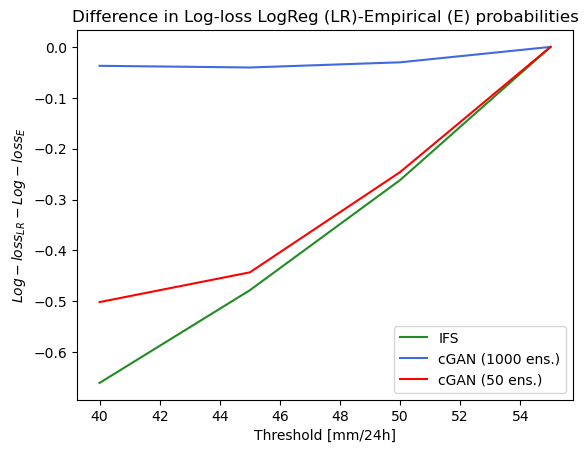

In [1110]:
colours = ['forestgreen','royalblue','red']
labels = ['IFS','cGAN (1000 ens.)', 'cGAN (50 ens.)']

i=0
for model in ['IFS','cGAN','cGAN_50']:
    
    plt.plot(np.arange(40,60,5),(logreg_ll[model]-empirical_ll[model]),color=colours[i],label=labels[i])
    i+=1


plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'mathtext.default':'regular'}) 
plt.rcParams.update({'mathtext.default':'it'}) 

plt.legend()
plt.title('Difference in Log-loss LogReg (LR)-Empirical (E) probabilities')
plt.xlabel('Threshold [mm/24h]')
plt.ylabel(r'$Log-loss_{LR}-Log-loss_{E}$')
             

(0.0, 0.6)

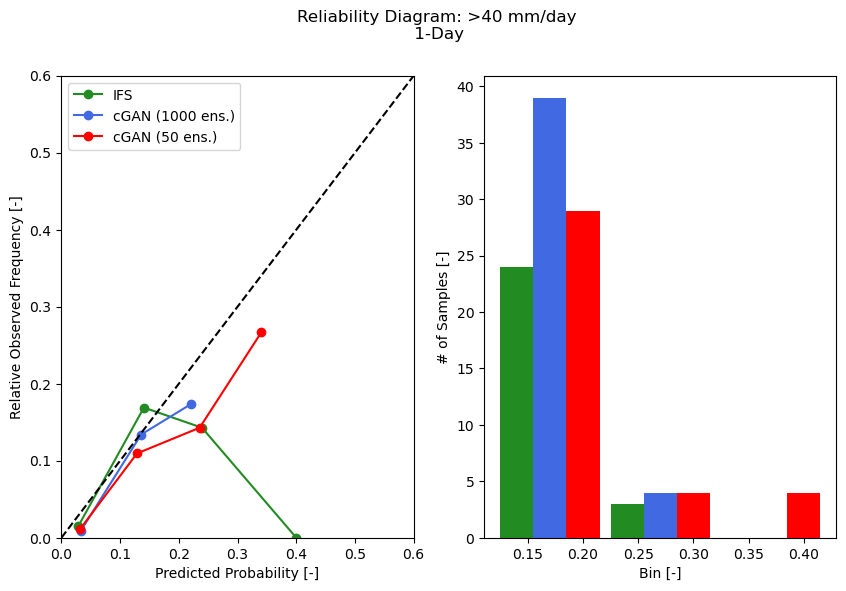

In [1114]:
import matplotlib.pyplot as plt

colours = ['forestgreen','royalblue','red']
labels = ['IFS','cGAN (1000 ens.)', 'cGAN (50 ens.)']
threshold = 0

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

i=0
offset = 0
for model in ['IFS','cGAN','cGAN_50']:
    ax1.plot(logreg_cal_curve[model][threshold,1,:],logreg_cal_curve[model][threshold,0,:],'o-',color=colours[i],label=labels[i])
    ax2.bar(np.asarray([0.14,0.24,0.34])+offset,logreg_cal_curve[model][threshold,2,1:-1],color=colours[i],width=0.03)
    i+=1
    offset+=0.03
ax1.plot([0,1],[0,1],'k',linestyle='dashed')

plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'mathtext.default':'regular'}) 
plt.rcParams.update({'mathtext.default':'it'}) 

ax1.legend()
plt.suptitle('Reliability Diagram: >40 mm/day\n 1-Day',y=0.99)
ax1.set_xlabel('Predicted Probability [-]')
ax1.set_ylabel(r'Relative Observed Frequency [-]')
ax2.set_ylabel(r'# of Samples [-]')
ax2.set_xlabel(r'Bin [-]')

ax1.set_xlim(0,0.6)
ax1.set_ylim(0,0.6)


In [1005]:
model = "cGAN_50"
region = "DAGORETTI"

gridsearch_results[model][40].best_params_

{'logreg__l1_ratio': np.float64(0.8999999999999999),
 'spline__knots': 'uniform',
 'spline__n_knots': 10}